# Plotting of the Covid-19/Heat survey data

In [1]:
# Import packages
using LinearAlgebra
using CSV
using DataFrames
using Plots
using StatsPlots
using StatsBase
import DataStructures

## Set parameters for the later plotting

- You can set the country variable to any of: Cameroon, India, Indonesia and Pakistan
- The wave variable can be 1 or 2

In [2]:
country = "Cameroon";
wave = "2";

## Set path and read data

In [3]:
mkpath(joinpath("plots", country * "_Wave_" * wave))
filename = "Cool Infrastructures " * country * " Raw Data Wave " * wave * ".csv"
absolute_path = joinpath(pwd(), "data", filename)
df = DataFrames.DataFrame(CSV.read(absolute_path, DataFrame))
first(df, 3)

,Country,OptIn Date,Language,Agree,AgeGroup,City,Gender,Occupation_raw
,String,String,String,String,String,String,String,String
1,Cameroon,19/07/2020,French,Yes,18-24,DOUALA,FEMALE,HELP FROM FAMILY AND/OR FRIENDS [FROM INSIDE OF THE COUNTRY]
2,Cameroon,17/07/2020,French,Yes,35+,DOUALA,MALE,PAID LABOR/WAGE
3,Cameroon,15/07/2020,French,Yes,25-34,DOUALA,MALE,EMPLOYED IN PRIVATE COMPANY


In [4]:
names(df)

83-element Array{String,1}:
 "Country"
 "OptIn Date"
 "Language"
 "Agree"
 "AgeGroup"
 "City"
 "Gender"
 "Occupation_raw"
 "Occupation"
 "OwnHouse"
 "CoolHome"
 "Electricity"
 "HoursDay"
 ⋮
 "ExperienceBeforeHeat (Irrational behaviour)"
 "ExperienceBeforeHeat (Rash)"
 "ExperienceBeforeHeat (Muscle cramps)"
 "ExperienceBeforeHeat (Clammy skin)"
 "ExperienceBeforeHeat (Confusion)"
 "ExperienceBeforeHeat (Dizziness)"
 "ExperienceBeforeHeat (Vomiting)"
 "ExperienceBeforeHeat (Feeling listless/lack of engagement with social activities/family)"
 "FeelingMore"
 "PhysicalConflict"
 "HeatAffect"
 "Language2"

## Plot histograms for individual questions

Change the column name to any of the names. Alternatively you can uncomment (remove '#') the next line and pick any number which corresponds to the order of the columns, e.g. 2 corresponds to "OptIn Date".

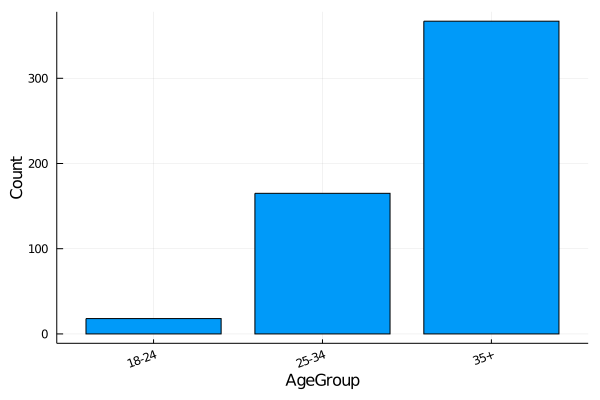

In [5]:
columnname = "Occupation"
columnname = names(df)[(5)]

# Plot the histogram
datamap = countmap(df[!,columnname])
datamap = DataStructures.SortedDict(datamap)
bar((x -> datamap[x]).(keys(datamap)), xticks=(1:length(keys(datamap)), keys(datamap)), legend=false, xrotation=20)
xlabel!(columnname)
ylabel!("Count")

## Plot the heatmap of the different experiences

In [ ]:
ii = 0
# Collect all the experience column names
experience_names =[]
for columnname in names(df)
    if occursin("Experience_", columnname)!
        ii += 1
        push!(experience_names, columnname)
        #println("$(columnname) is experience number $(ii)");
    end
end
println(experience_names)

# Generate dataframe with only the Experience columns
df2 = select(df, experience_names)

N = ii
B = zeros(Int16, N, N)

for i in 1:nrow(df2)
    temp = []
    jj = 0
    for j in names(df2)
        jj += 1
        if ~ismissing(df2[i,j]) && (occursin("Yes", df2[i,j]) || occursin("YES", df2[i,j]))
            push!(temp, jj)
        end
    end
    # Add 1 for each non-zero element
    while ~isempty(temp)
        B[temp[1], temp[1:end]] .+=1
        deleteat!(temp, 1)
    end
end

using LinearAlgebra
Bu=Symmetric(UpperTriangular(B))

Any["Experience_Blurred vision", "Experience_Clammy skin", "Experience_Concentration loss", "Experience_Confusion", "Experience_Convulsions", "Experience_Dizziness", "Experience_Fainting [brief loss of consciousness]", "Experience_Fatigue", "Experience_Feeling hot", "Experience_Feeling listless/lack of engagement with social activities/family", "Experience_Feeling sweaty", "Experience_Feeling thirsty", "Experience_Headache", "Experience_Irrational behaviour", "Experience_Loss of consciousness [extensive]", "Experience_Muscle c

In [ ]:
# Find the text between the parentheses
short_names = []
for nm in experience_names
    #push!(short_names, split(split(nm, '(')[2], ')')[1])
    push!(short_names, split(nm, '_')[2])  
end
    
xlabel = string.(collect(1:N))
ylabel = string.(collect(short_names))
#ylabel = string.(collect(1:N))
heatmap(Bu, xticks=(1:N, xlabel), yticks=(1:N, ylabel),
    fill_z=Bu, aspect_ratio=:equal, xrotation=0, dpi=200)#, size=(600,400))

fontsize = 5
nrows, ncols = size(Bu)
ann = [(i,j, text(Bu[i,j], fontsize, :white, :center))
            for i in 1:nrows for j in 1:ncols]
annotate!(ann, linecolor=:white)

## Scatter plots for column combinations

Plot the number of occurences of all combinations of answers from the two columns. The size of the markers indicate the number of occurences for each combination.

Change the column names to any of the names. Alternatively you can uncomment (remove '#') the other two lines and pick any number which corresponds to the order of the columns, e.g. 2 corresponds to "OptIn Date".

In [ ]:
column_x = "RoofingMaterial"
#column_x = = names(df)[19]
column_y = "WallMaterial"
#column_y = names(df)[20]

# Group all combinations from the two columns
df2 = DataFrame(x = Any[], y = Any[], groupcount = Int64[])
for (key, subdf) in pairs(groupby(df, [column_x, column_y]))
    println("Number of data points for $(key[column_x]) - $(key[column_y]): $(nrow(subdf))")
    push!(df2, [key[column_x], key[column_y], nrow(subdf)])
end

# Calculate the maximum number to rescale the marker
max_count = maximum(df2[!,:groupcount]) * 0.05

scatter(df2[!,:x], df2[!,:y], markersize=df2[!,:groupcount]/max_count, legend=false, xrotation=35)
title!("Absolute numbers")
xlabel!(column_x)
ylabel!(column_y)

## Plot the same as bar chart

In [ ]:
# Plot the data as bar chart
groupedbar(df2[!,:x], df2[!,:groupcount], group = df2[!,:y], ylabel = "Count", 
           title="$(column_x) grouped with $(column_y)",
           xrotation=20, legend = :outertopright)
xlabel!(column_x)
ylabel!("Count")